<a href="https://colab.research.google.com/github/diegoesteve/shared/blob/master/LAB02_DiegoE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1>Time series analysis</h1></center>
<center><h2>Lab 2: Holt-Winters exponential smoothing - Diego Esteve</h2></center>
<br>


In [0]:
import sys
IN_COLAB = 'google.colab' in sys.modules
DATA_FILE = 'datasets/demanda.csv'
RAW_REPO = 'https://github.com/DiploDatos/AnalisisSeriesTemporales/raw/master/'
print(IN_COLAB)
IN_COLAB=True
if IN_COLAB:
    DATA_FILE = RAW_REPO + DATA_FILE
    !wget -O get-x13as.sh {RAW_REPO + 'get-x13as.sh'}
    !sh get-x13as.sh
    !wget -O plotting.py {RAW_REPO + 'plotting.py'}

True
--2019-09-21 22:22:41--  https://github.com/DiploDatos/AnalisisSeriesTemporales/raw/master/get-x13as.sh
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DiploDatos/AnalisisSeriesTemporales/master/get-x13as.sh [following]
--2019-09-21 22:22:41--  https://raw.githubusercontent.com/DiploDatos/AnalisisSeriesTemporales/master/get-x13as.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 236 [text/plain]
Saving to: ‘get-x13as.sh’

get-x13as.sh        100%[===================>]     236  --.-KB/s    in 0s      

2019-09-21 22:22:42 (27.9 MB/s) - ‘get-x13as.sh’ saved [236/236]

--2019-09-21 22:22:43-- 

In [0]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [0]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 4]

## Data: Demanda de Energía en Argentina. 

In [0]:
data = pd.read_csv(DATA_FILE, index_col='TIPO', parse_dates=True, dayfirst=True)
#data = pd.read_csv(DATA_FILE)
data.tail()

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
TIPO,,,,
2019-03-01,4004709.444,3044854.983,3072063.284,1.012163e+07
2019-04-01,3652724.519,2892482.731,3029687.889,9.574895e+06
2019-05-01,4356836.823,2973830.213,3055527.035,1.038619e+07
2019-06-01,4816838.191,2937048.667,2897618.673,1.065151e+07
2019-07-01,5704951.016,3288949.873,3035538.422,1.202944e+07


In [0]:
y = data['TOTAL'].copy() 
y.index = y.index.to_period(freq='M')

ts = data['TOTAL'] # indexed series

In [0]:
data.describe().round(2)

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
count,79.00,79.00,79.00,79.00
mean,4551935.29,3113096.42,3187977.02,10853008.74
std,654164.93,206829.98,124659.74,816874.81
min,3239380.70,2809183.13,2897618.67,9307334.16
25%,3990580.45,2948084.14,3109179.19,10223259.40
50%,4470715.12,3070853.24,3199317.20,10706955.32
75%,5092450.46,3270751.91,3275571.56,11476364.98
max,6193110.21,3606989.07,3460879.97,12607552.72


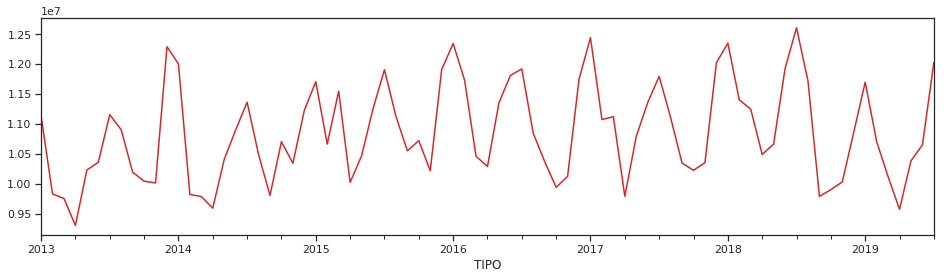

In [0]:
y.plot(color=red, figsize=(16,4))

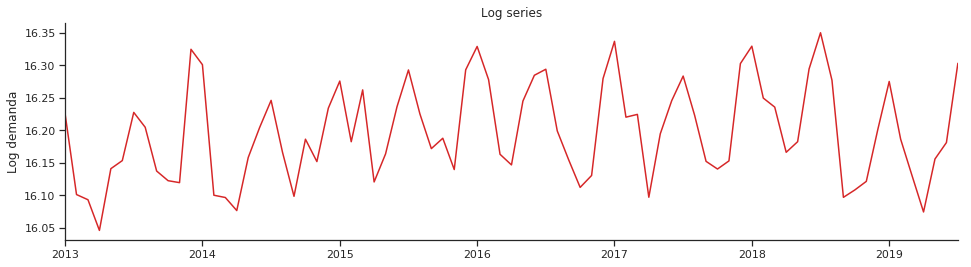

In [0]:
fig, ax= plt.subplots(figsize=(16,4))
np.log(y).plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Log demanda')
ax.set_title('Log series')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

## Descomposición de las series  

In [0]:
decomposition = sm.tsa.x13_arima_analysis(ts,x12path='.')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/x13.py:187: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in the estimated spectrum of the regARIMA residuals.
  
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


You can use the <TT>dir</TT> method to check the available output. 

In [0]:
[attr for attr in dir(decomposition) if not attr.startswith('_')]

['irregular', 'observed', 'plot', 'results', 'seasadj', 'stdout', 'trend']

For example, if we want to retrieve and plot the seasonally adjusted component, we can do as follows.

In [0]:
decomposition.seasadj.tail().round(2)

TIPO
2019-03-01    10252052.84
2019-04-01    10454843.75
2019-05-01    10423639.58
2019-06-01    10217740.23
2019-07-01    10895319.58
Name: seasadj, dtype: float64

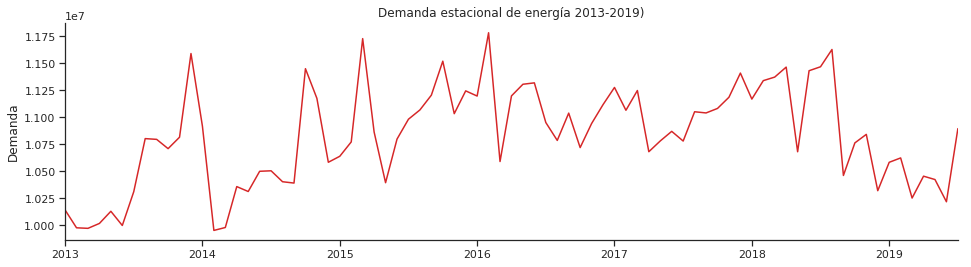

In [0]:
fig, ax= plt.subplots(figsize=(16,4))
decomposition.seasadj.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Demanda')
ax.set_title('Demanda estacional de energía 2013-2019)')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

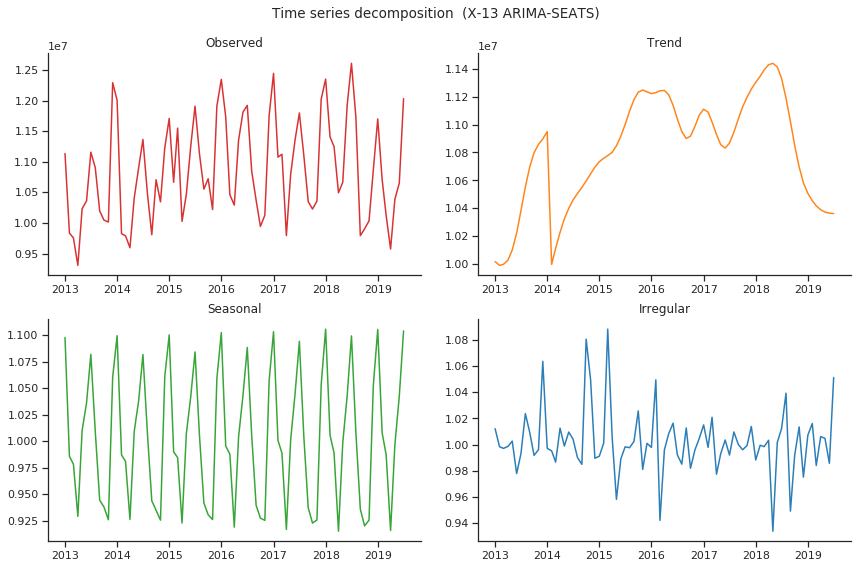

In [0]:
from plotting import plot_components_x13
plot_components_x13(decomposition)
plt.show()

## Tendencia exponencial suavizada corregida

In [0]:
z=decomposition.seasadj.copy()
z.index=ts.index.to_period(freq='M')

In [0]:
model_sm = sm.tsa.Holt(z).fit()
smoothed_sm = model_sm.fittedvalues
mse_sm = sm.tools.eval_measures.rmse(z,smoothed_sm)
print(' In-sample fit:')
print(' RMSE               {0:.2f}'.format(mse_sm))
model_sm.summary()

 In-sample fit:
 RMSE               373399.61


Dep. Variable:,endog,No. Observations:,79
Model:,Holt,SSE,11014754117819.137
Optimized:,True,AIC,2035.204
Trend:,Additive,BIC,2044.682
Seasonal:,None,AICC,2036.371
Seasonal Periods:,None,Date:,"Sat, 21 Sep 2019"
Box-Cox:,False,Time:,22:54:16
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3839538,alpha,True
smoothing_slope,0.000000,beta,True


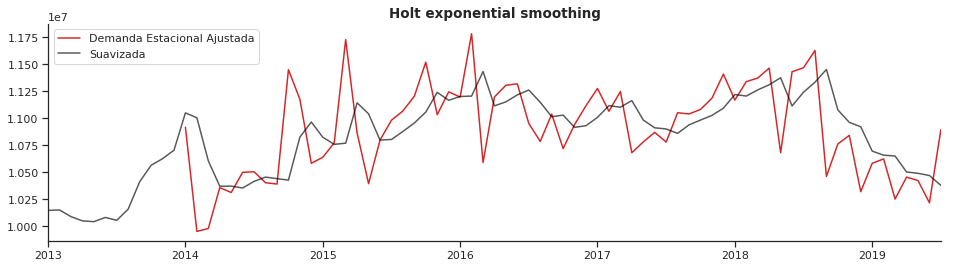

In [0]:
fig, ax= plt.subplots(figsize=(16,4))

z['2014':].plot(color='#D62728', label='Demanda Estacional Ajustada')
smoothed_sm['2013':].plot(color='black', label='Suavizada', alpha=0.65)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


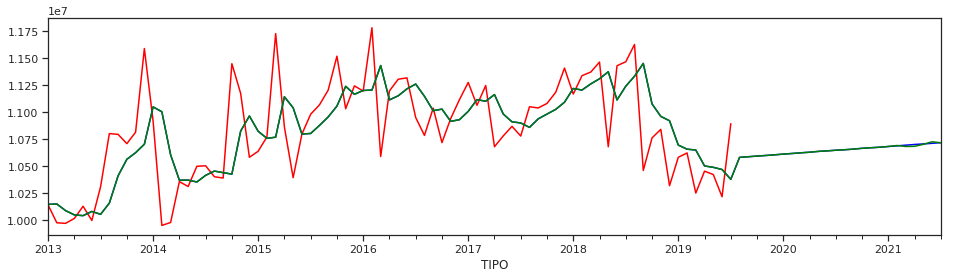

In [0]:
h=2*12 #M
w=h*4
data = z
model = sm.tsa.Holt
pred_index = data.index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_fit = None
for i in range(0,h):
    current = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current).fit()
    if i==0:
        orig_fit = expanding.fittedvalues
    rolling = model(current.tail(w)).fit()
    pred_expanding.update(expanding.forecast(1))
    pred_rolling.update(rolling.forecast(1))
ax = data[-w:].plot(color='red', figsize=(16,4))
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_fit[-w:],pred_rolling]).plot(ax=ax,color='green');

## Holt-winters exponential smoothing


In [0]:
def hw_summary(model_sm):
    rmse_sm = sm.tools.eval_measures.rmse(model_sm.data.endog,model_sm.fittedvalues)
    print(' In-sample fit:')
    print(' RMSE               {0:.2f}'.format(rmse_sm))
    return model_sm.summary()

In [0]:
ahw_sm=sm.tsa.ExponentialSmoothing(y, trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()

In [0]:
hw_summary(ahw_sm)

 In-sample fit:
 RMSE               471015.01


Dep. Variable:,endog,No. Observations:,79
Model:,ExponentialSmoothing,SSE,17526556334113.439
Optimized:,True,AIC,2095.898
Trend:,Additive,BIC,2133.809
Seasonal:,Additive,AICC,2107.298
Seasonal Periods:,12,Date:,"Sat, 21 Sep 2019"
Box-Cox:,False,Time:,22:56:38
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1667932,alpha,True
smoothing_slope,4.611e-09,beta,True


In [0]:
mhw_sm=sm.tsa.ExponentialSmoothing(y, trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
hw_summary(mhw_sm)

 In-sample fit:
 RMSE               373386.18


Dep. Variable:,endog,No. Observations:,79
Model:,ExponentialSmoothing,SSE,11013962177297.572
Optimized:,True,AIC,2059.198
Trend:,Additive,BIC,2097.109
Seasonal:,Multiplicative,AICC,2070.598
Seasonal Periods:,12,Date:,"Sat, 21 Sep 2019"
Box-Cox:,False,Time:,22:56:52
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3555951,alpha,True
smoothing_slope,2.2473e-13,beta,True


In [0]:
mhw_damped=sm.tsa.ExponentialSmoothing(y, trend='add', damped=True, seasonal='mul', seasonal_periods=12).fit()
hw_summary(mhw_damped)

 In-sample fit:
 RMSE               373992.563


Dep. Variable:,endog,No. Observations:,79
Model:,ExponentialSmoothing,SSE,11049764539979.836
Optimized:,True,AIC,2061.455
Trend:,Additive,BIC,2101.735
Seasonal:,Multiplicative,AICC,2074.336
Seasonal Periods:,12,Date:,"Sat, 21 Sep 2019"
Box-Cox:,False,Time:,22:07:10
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3601600,alpha,True
smoothing_slope,0.0526473,beta,True


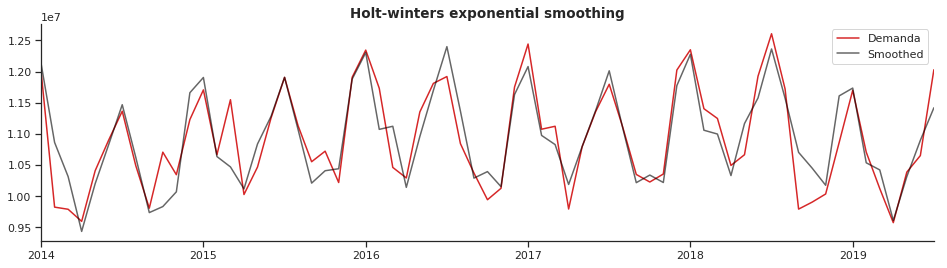

In [0]:
smoothed=pd.Series(mhw_damped.fittedvalues, index=y.index)

fig, ax= plt.subplots(figsize=(16,4))

y['2014':].plot(color='#D62728', label='Demanda')
smoothed['2014':].plot(color='black', label='Smoothed', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt-winters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

## Diagnóstico de modelo
 

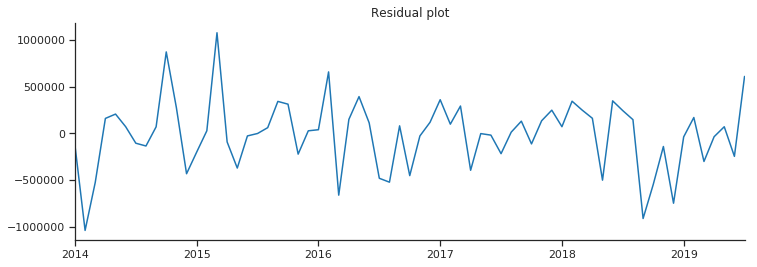

In [0]:
resid = (y-mhw_damped.fittedvalues)[12:] # we remove the first 12 observations as they are for initialisitation only

fig, ax= plt.subplots(figsize=(12,4))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual')
sns.despine()
plt.show()

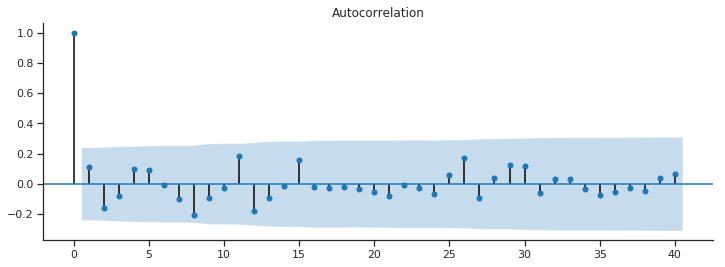

In [0]:
fig, ax = plt.subplots(figsize=(12,4))
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax)
sns.despine()
plt.show()

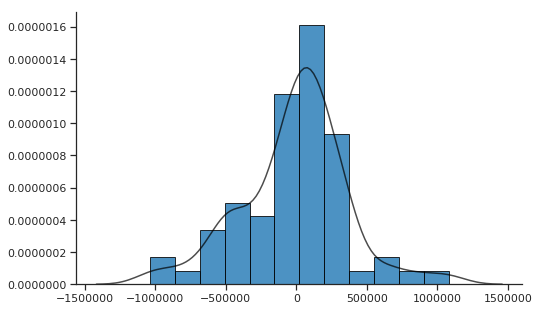

In [0]:
from plotting import histogram

histogram(resid)
plt.show()


## Validación del modelo

In [0]:
start_val = y.index[-round(len(y)/12*.2)*12]
start_val

Period('2018-08', 'M')

In [0]:
# Real time forecasting 

validation=y[start_val:].index
start = y.index.get_loc(start_val) 

pred1 = [] # seasonal random walk
pred2 = [] # additive holt winters
pred3 = [] # multiplicative holt winters
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-12]) # seasonal random walk forecast
    
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()
    pred2.append(model.forecast(1)[0]) # additive holt winters forecast
    
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
    pred3.append(model.forecast(1)[0]) # multiplicate holt winters forecast
    

columns=['Seasonal RW', 'Additive', 'Multiplicative', 'Actual']
results = np.vstack([pred1,pred2,pred3,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

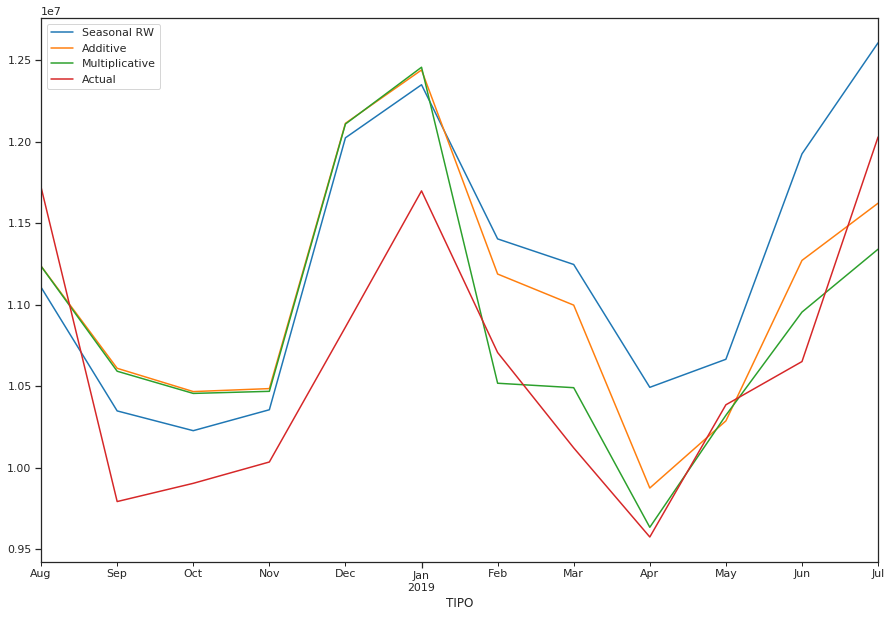

In [0]:
results.plot();

In [0]:
from scipy import stats

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(len(results.columns)-1):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results.iloc[:,i], results.iloc[:,-1])
    table.iloc[i,1] = (results.iloc[:,i] - results.iloc[:,-1]).sem()
table.round(3)

,RMSE,SE
Seasonal RW,779964.344,148054.667
Additive,657481.478,150961.652
Multiplicative,594538.757,161497.230


## Forecast
Predecimos 2 años en función del modelo elegido

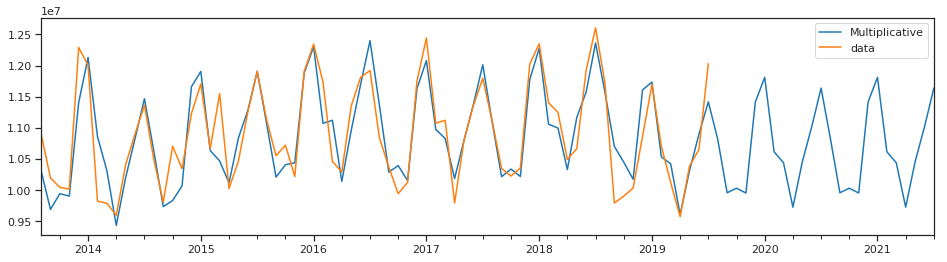

In [0]:
h=2*12 #M
w=h*3

model = sm.tsa.ExponentialSmoothing(y,trend='add', damped=True, seasonal='mul', seasonal_periods=12).fit()

plot = pd.DataFrame()
plot['Multiplicative'] = pd.concat([model.fittedvalues, model.forecast(h)])
plot['data'] = y

plot[-(w+h):].plot();#figsize=(9,6))